In [80]:
import os
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

### CONFIGURAÇÕES GLBOAIS
- Todos os arquivos de áudio .wav na pastas de "files" devem ter 1 segundo de duração, para serem convertidos em arrays de tamanho tamanho fixo 16000.
- Cada arquivo de áudio tera uma label associada, cada label se refere a classe que será usada para detecção 

In [81]:
def getFileFromFolder(path, index):
    files = os.listdir(path)
    return os.path.join(path, files[index])


filePath = getFileFromFolder(r'files\yes', 1)
filePath

'files\\yes\\00f0204f_nohash_0.wav'

In [82]:
tf.random.set_seed(42)
np.random.seed(42)

AUTOTUNE = tf.data.AUTOTUNE
WAVE_LENGTH = 1 * 16000 # 1 seg

classes = os.listdir('files')
classes

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

# PREPARAÇÃO DOS DADOS

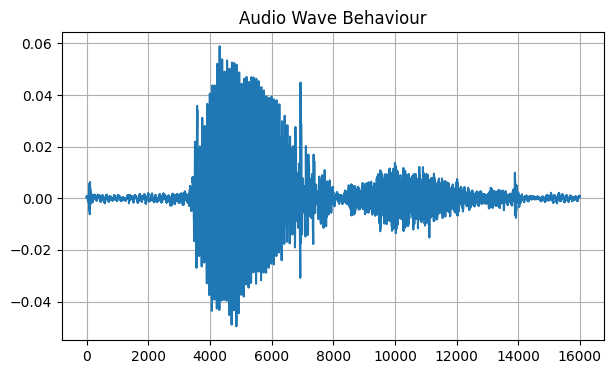

In [83]:
def getWave(audioPath):
    file = tf.io.read_file(audioPath)
    audio, _ = tf.audio.decode_wav(contents=file)
    return tf.squeeze(audio, axis=-1)


wave = getWave(filePath)
plt.figure(figsize=(7, 4))
plt.title('Audio Wave Behaviour')
plt.plot(wave)
plt.grid()

In [84]:
def getLabel(filePath):
    parts = tf.strings.split(input=filePath, sep=os.path.sep)
    return parts[-2]


label = getLabel(filePath)
label

<tf.Tensor: shape=(), dtype=string, numpy=b'yes'>

In [85]:
def displayWave(wave):
    audio = display.Audio(wave, rate=WAVE_LENGTH)
    display.display(audio)


print(f'Reprodução da classe "{label.numpy().decode()}"')
displayWave(wave)

Reprodução da classe "yes"


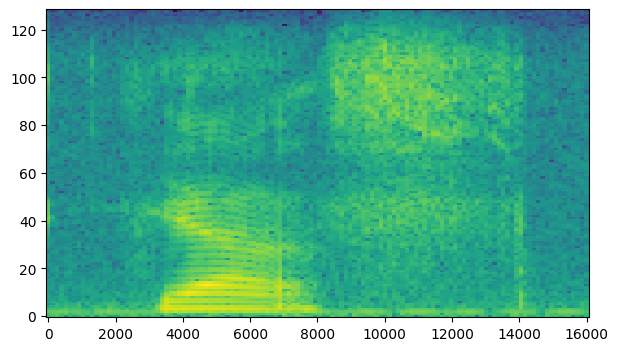

In [86]:
def getSpectrogram(waveform):
    input_len = WAVE_LENGTH
    waveform  = waveform[:input_len]
    zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)

    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    # aumente frame_length e frame_step para precisão
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def plotSpectrogram(spectrogram):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    
    plt.figure(figsize=(7, 4))
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    xData = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    yData = range(height)
    plt.pcolormesh(xData, yData, log_spec)
    plt.show()


spec = getSpectrogram(wave)
plotSpectrogram(spec)

- **Divisão de Dados** $\Rightarrow$ 80% dos dados para treino e 20% dos dados para teste

In [87]:
filenames = tf.io.gfile.glob('files' + '/*/*')
filenames = tf.random.shuffle(filenames)
numFiles  = len(filenames)
numFiles

8000

In [88]:
trainSize = int(numFiles * 0.8)
validSize = int(numFiles * 0.1)
testSize  = int(numFiles * 0.1)

(trainSize, validSize, testSize)

(6400, 800, 800)

In [89]:
trainFiles = filenames[:trainSize]
validFiles = filenames[trainSize: trainSize + validSize]
testFiles  = filenames[-testSize:]

print('Training set size:   ', len(trainFiles))
print('Validation set size: ', len(validFiles))
print('Test set size:       ', len(testFiles))

Training set size:    6400
Validation set size:  800
Test set size:        800


- **filesDataset**: Dataset inicial que contém os caminhos dos arquivos de áudio (strings com os endereços dos arquivos).
- **waveDataset**:  Dataset processado que contém a forma de onda do áudio e o rótulo (categoria ou classe) extraído do caminho do arquivo.

In [90]:
def getWaveformInfo(filePath):
    label    = getLabel(filePath)
    waveform = getWave(filePath)
    return (waveform, label)

def getSpectrogramInfo(audio, label):
    spectrogram = getSpectrogram(audio)
    label_id    = tf.argmax(label == classes)
    return spectrogram, label_id


filesDataset = tf.data.Dataset.from_tensor_slices(trainFiles)
waveDataset  = filesDataset.map(map_func=getWaveformInfo, num_parallel_calls=AUTOTUNE)
spectogramDataset = waveDataset.map(map_func=getSpectrogramInfo, num_parallel_calls=AUTOTUNE)

In [91]:
def processDataset(files):
    files_ds  = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(map_func=getWaveformInfo, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(map_func=getSpectrogramInfo, num_parallel_calls=AUTOTUNE)
    return output_ds


trainDataset = spectogramDataset
validDataset = processDataset(validFiles)
testDataset  = processDataset(testFiles)

In [92]:
batch_size = 64
trainDataset = trainDataset.batch(batch_size)
validDataset = validDataset.batch(batch_size)
trainDataset = trainDataset.cache().prefetch(AUTOTUNE)
validDataset = validDataset.cache().prefetch(AUTOTUNE)

In [93]:
def getInputShape(spectogramDataset):
    for spectogram, _ in spectogramDataset.take(1):
        input_shape = spectogram.shape

    return input_shape


inputShape = getInputShape(spectogramDataset)
inputShape

TensorShape([124, 129, 1])

# MODELO

In [94]:
def createModel(classes, spectogramDataset):
    inputShape = getInputShape(spectogramDataset)
    num_labels = len(classes)
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=spectogramDataset.map(map_func=lambda spec, label: spec))

    return models.Sequential([
        layers.Input(shape=inputShape),
        layers.Resizing(32, 32), # Downsample the input.
        norm_layer,              # Normalize.
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])


model = createModel(classes, spectogramDataset)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [95]:
def trainModel(model, epochs=20):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    return model.fit(
        trainDataset,
        validation_data=validDataset,
        epochs=epochs,
        callbacks=[early_stop, checkpoint]
    )


history = trainModel(model, epochs=50)
history

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2862 - loss: 1.9146 - val_accuracy: 0.5838 - val_loss: 1.3161
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5675 - loss: 1.2830 - val_accuracy: 0.7000 - val_loss: 0.9071
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6946 - loss: 0.8868 - val_accuracy: 0.7312 - val_loss: 0.7954
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7608 - loss: 0.7063 - val_accuracy: 0.7812 - val_loss: 0.7004
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7941 - loss: 0.5790 - val_accuracy: 0.8175 - val_loss: 0.6006
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8206 - loss: 0.5153 - val_accuracy: 0.8175 - val_loss: 0.5862
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8386 - loss: 0.4525 - val_accuracy: 0.8275 - val_loss: 0.5538
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8605 - loss: 0.3988 - val_accu

(<matplotlib.legend.Legend at 0x1711dd1b350>, None)

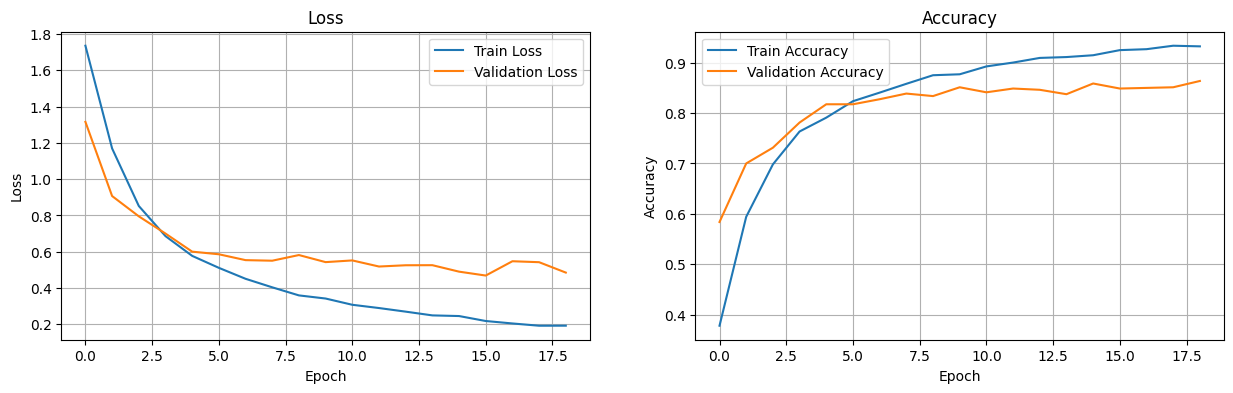

In [96]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(), plt.grid()


# VALIDAÇÃO

In [97]:
xTest = np.array([audio.numpy() for audio, label in testDataset])
yTest = np.array([label.numpy() for audio, label in testDataset]) 
yModel = np.argmax(model.predict(xTest), axis=1)

test_acc = sum(yModel == yTest) / len(yTest)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test set accuracy: 84%


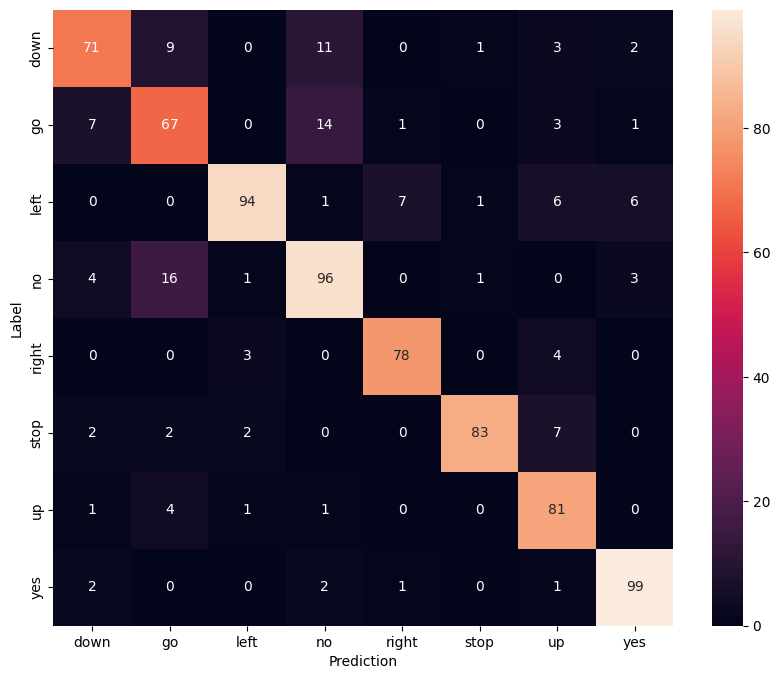

In [98]:
confusion_mtx = tf.math.confusion_matrix(yTest, yModel)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [99]:
def getProbabilities(filePath, classes):
    dataset = processDataset([filePath])

    for spectrogram, label in dataset.batch(1):
        prediction = model(spectrogram)
        
        probabilities = tf.nn.softmax(prediction[0]).numpy()
        probabilities = [round(p, 3) for p in probabilities]
        return {classes[i]: prob for i, prob in enumerate(probabilities)}
    

filePath = getFileFromFolder(r'files\no', 5)
probabilities = getProbabilities(filePath, classes)
print(probabilities)

{'down': 0.006, 'go': 0.108, 'left': 0.0, 'no': 0.884, 'right': 0.0, 'stop': 0.0, 'up': 0.0, 'yes': 0.001}


In [100]:
def predictAudio(filePath, model, classes):
    dataset = processDataset([filePath]).batch(1) 
    spectrogram, _ = next(iter(dataset)) 
    prediction = model(spectrogram)
    probabilities   = tf.nn.softmax(prediction[0])
    predicted_class = tf.argmax(probabilities).numpy()
    return classes[predicted_class], np.max(probabilities)


filePath = getFileFromFolder(r'files\down', 3)
print(filePath)

prediction = predictAudio(filePath, model, classes)
prediction

files\down\0132a06d_nohash_1.wav


('down', 0.8943713)

In [101]:
model.save('model.keras')
del model

In [102]:
model = tf.keras.models.load_model('model.keras')
prediction = predictAudio(filePath, model, classes)
prediction

('down', 0.8943713)